# Plot schematic of self-similarity of earthquakes

2024.06.28 Kurama Okubo

- 2024.12.3 update for the AGU2024 presentation.
- 2025.1.7 update for the introduction figure.

In [1]:
import os

import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import matplotlib as mpl
%matplotlib inline
import glob
from glob import glob
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
from tqdm import tqdm
import warnings
import time
import pickle 
import seaborn as sns

%load_ext autoreload
%autoreload 2

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 4.75
plt.rcParams["xtick.major.width"] = 0.75
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["xtick.minor.width"] = 0.4
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 4.75
plt.rcParams["ytick.major.width"] = 0.75
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["ytick.minor.width"] = 0.4
plt.rcParams["ytick.minor.visible"] = True

plt.rcParams["savefig.transparent"] = True

plt.rcParams['axes.linewidth'] = 0.75


### Self-similar source time function

We compute the synthetic self-similar source time function with the equivalent seismic moment. 

The formulation of the seismic moment and duration is

$$ M_0 = \dfrac{16}{7} \Delta \sigma \left( \dfrac{k}{2\pi} \beta T_R \right) ^3 $$

where $k$ is 1.99 for P spectrum of Madariaga's circular fault model with rupture velocity is 0.9$\beta$. $T_R$ is the proxy of source duration such as $1/\omega_c$.
Considering the constant stress drop and the similar coefficient of $k$, i.e., same rupture velocity, the scaling of moment and duration is written as follows:

$$ M_0 = \gamma T_R^3. $$

Thus,
$$ T_R = cM_0^{1/3} $$  

Generally, we estimate the scaling as $T_R = cM_0^{\alpha}$.

- STF of Küpper wavelet

reference: e.g., muller1970., Maeda et al (2017).

$$ STF(t) = \dfrac{3\pi}{4T_R} \sin^3 (\dfrac{\pi t}{T_R}). $$

The seismic moment is the integral of this, and is equal to unity as it is normalized.

We determine the coefficient $c$ with the minimum event in this notebook. 

In [2]:
def stf_cosine(t, TR, fz):
    '''
        source time function of cosine wavelet
        https://tktmyd.github.io/OpenSWPC/English/2._Parameter_Settings/0207_source/
        Argument: 
            t:: time vector
    '''
    stf = np.zeros(len(t))
    for i, tt in enumerate(t):
        if 0<tt and tt<TR:
            stf[i] = (fz/TR) * (1 - np.cos((2*np.pi*tt/TR)))
        else:
            stf[i] = 0
            
    return stf

In [3]:
def stf_kupper(t, TR, fz):
    '''
        source time function of Küpper wavelet
        https://tktmyd.github.io/OpenSWPC/English/2._Parameter_Settings/0207_source/
        Argument: 
            t:: time vector
    '''
    stf = np.zeros(len(t))
    for i, tt in enumerate(t):
        if 0<tt and tt<TR:
            stf[i] = fz * ((3 * np.pi)/(4 * TR)) * np.sin(np.pi * tt/TR)**3
        else:
            stf[i] = 0
            
    return stf

# Read the event catalog

In [4]:
# read gouge event catalog
expr_id = 87
gougepatch_id = "G3"
Qinv_quart = 50

Nvalidsensors_thresh = 4

finame = f"../../../GougeEventCatalog/data/gougeeventcatalog__fb03-{expr_id:03d}__{gougepatch_id}__Q{Qinv_quart}.csv"
df_gc = pd.read_csv(finame, index_col=0)
df_gc_selected = df_gc[df_gc["Nvalidsensors"] >= Nvalidsensors_thresh].copy()
df_gc_selected.head()

,location,event_onset_time,stickslip_id,event_label,Q_correction_quart,Nvalidsensors,M0,M0_std,Mw,Tw,Tw_std
event_id,,,,,,,,,,,
4,1.75,42.474772,3,A,50,4,0.592607,0.178671,-6.218156,0.000003,1.530315e-07
9,1.75,47.662693,5,F,50,4,0.046991,0.007419,-6.951990,0.000002,3.643121e-07
18,1.75,56.727044,8,F,50,4,0.755830,0.192507,-6.147717,0.000003,3.100882e-07
19,1.75,59.103175,9,F,50,4,0.055755,0.016951,-6.902476,0.000002,2.699155e-07
20,1.75,59.103526,9,F,50,4,0.865466,0.210250,-6.108500,0.000003,1.352659e-07


In [5]:
M0_mean = df_gc_selected.sort_values(by="M0").M0
Tw_mean = df_gc_selected.sort_values(by="M0").Tw

In [6]:
M0_mean.head()

event_id
128    0.012927
126    0.017021
21     0.021466
9      0.046991
19     0.055755
Name: M0, dtype: float64

In [7]:
Tw_mean.head()*1e6

event_id
128    2.231325
126    1.991559
21     2.309987
9      2.346274
19     2.484483
Name: Tw, dtype: float64

In [8]:
# # The variation of M0 from Qinv_quart 50 result
# M0_mean = np.array([0.01303659, 0.01691624, 0.02163488, 0.05577009, 0.06540957,
#        0.0684772 , 0.07657176, 0.18635364, 0.20211973, 0.26222699,
#        0.27319155, 0.32852531, 0.34865222, 0.48165184, 0.48259824,
#        0.48830061, 0.58415808, 0.5923466 , 0.69312544, 0.69794075,
#        0.71835837, 0.73879836, 0.75248949, 0.75870786, 0.78072679,
#        0.79024216, 0.80646432, 0.87277011, 0.90517182, 0.97249315,
#        1.13026941, 1.23430449])

# Synthesize the source time function

We synthesize the source time function based on the data from the gouge event catalog.
We select the three events, and use the seismic moment. Then, we compute the source duration by the scaling coefficient $T_R = cM_0^{\alpha}$.


In [9]:
gougeevent_ids = [24, 52, 129]
M0_min = M0_mean.loc[gougeevent_ids[0]]
M0_1 = M0_mean.loc[gougeevent_ids[1]] # np.median(M0_mean)
M0_2 = M0_mean.loc[gougeevent_ids[2]]

In [10]:
M0_min, M0_1, M0_2

(0.065639137, 0.48113795, 1.1312377)

In [11]:
# Tw_min = 2.5e-6 
Tw_min = Tw_mean.loc[gougeevent_ids[0]] # use the real data as Tw min
print(Tw_min*1e6)
scaling_coef_c = Tw_min/(M0_min**(1/3))
scaling_coef_c

2.4645085


6.109552009158324e-06

In [12]:
M0_try = [M0_min, M0_1, M0_2,]
N_M0 = len(M0_try)
Tw_try = []
for M0 in M0_try:
    Tw_try.append(scaling_coef_c * M0**(1/3))

In [13]:
Tw_try

[2.4645085e-06, 4.78739472967761e-06, 6.365912372997462e-06]

In [14]:
# Read the color synchronize with the waveform plots
# load color dictionary consistent to the plot of the repeated waveforms
repeated_sensor_lcdict = "OL08" # the color dict is same for all the sensor although separately saved.
with open(f'../../../ComputeScaling/data/01_plot_gougeevents/lc_dict_{gougepatch_id}_{repeated_sensor_lcdict}.pkl', 'rb') as fi:
    lc_dict = pickle.load(fi)



In [15]:
# cmap = sns.color_palette("viridis_r", as_cmap=True)
# skipcolor = 1
# c_norm = mpl.colors.Normalize(vmin=0, vmax=N_M0+skipcolor)

In [16]:
tvec = np.linspace(0, 10e-6, 1001) # time vector
dt = tvec[1]-tvec[0]
dt

1e-08

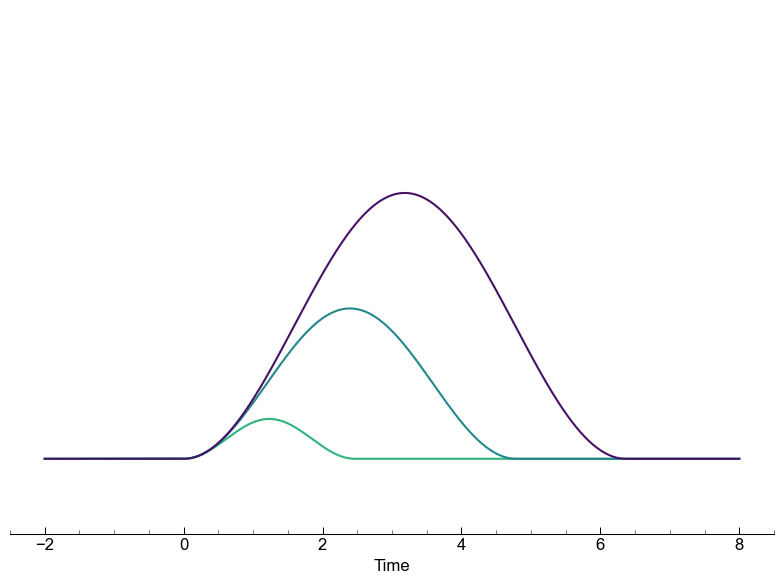

In [17]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))

troll = 2e-6 # roll the trace to insert zero before the onset of STF
nroll = int(np.round(troll/dt))

for i in range(N_M0):
    tr_cos = stf_cosine(tvec, Tw_try[i], M0_try[i])
    # tr_kupper = stf_kupper(tvec, Tw_try[i], M0_try[i])

    ax.plot((tvec-troll) * 1e6, np.roll(tr_cos, nroll), "-", c=lc_dict[f"fb03-{expr_id:03d}__{gougeevent_ids[i]:04d}"]) #c=cmap(c_norm(i+skipcolor)))

ax.set_xlabel("Time")
ax.get_yaxis().set_visible(False)
ax.spines[['left', 'right', 'top']].set_visible(False)

ax.set_ylim([-1e5, 0.6 * 1e6])

fig.tight_layout()

plt.savefig("./schematic_selfsimilar.eps",)
plt.savefig("./schematic_selfsimilar.png", dpi=70)


# Schematic of non-self-similar events

**Update:** using weak scaling of Tw with the M0.

For the non-self-similar events, the M0 is scaled as $T_R = cM_0^{\alpha}$.

In [18]:
scaling_alpha = 0.04 #0.04 # estimation of log-linear fit
M0_try_nonsim = [M0_min, M0_1, M0_2,] # same as the self-similar case
assert(M0_try == M0_try_nonsim)
N_M0 = len(M0_try_nonsim)
Tw_try_nonsim = []

scaling_coef_c_nonsim = Tw_min/(M0_min**(scaling_alpha))

for M0 in M0_try_nonsim:
    Tw_try_nonsim.append(scaling_coef_c_nonsim * M0**(scaling_alpha))

In [19]:
M0_try_nonsim

[0.065639137, 0.48113795, 1.1312377]

In [20]:
Tw_try_nonsim

[2.4645085e-06, 2.6689140650730363e-06, 2.7617601618696718e-06]

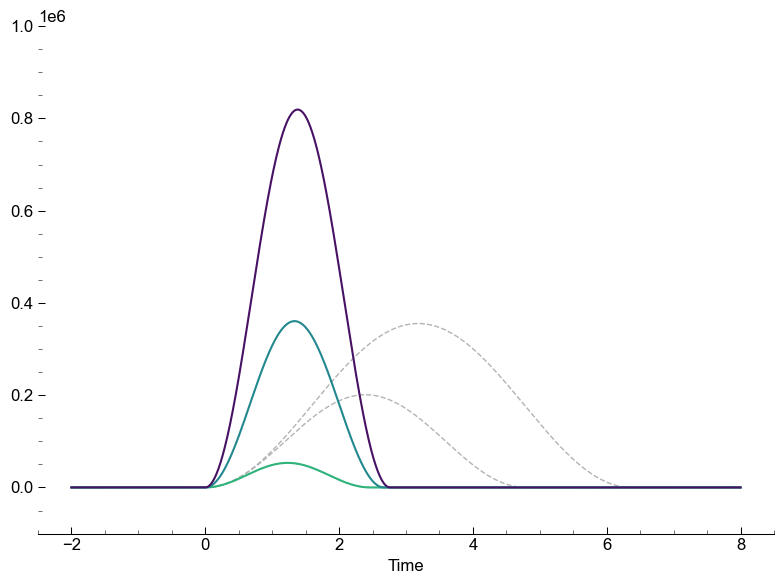

In [21]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))

troll = 2e-6 # roll the trace to insert zero before the onset of STF
nroll = int(np.round(troll/dt))

# amplify the self-similar STF for ease of visualization 
selfsim_ampnorm = 1.0 #1.5 # update: use 1.0 to represent the same M0

for i in range(N_M0):
    
    tr_cos = stf_cosine(tvec, Tw_try[i], M0_try[i])
    tr_kupper = stf_kupper(tvec, Tw_try[i], M0_try[i])
    
    tr_cos_nonselfsim = stf_cosine(tvec, Tw_try_nonsim[i], M0_try_nonsim[i])
    # tr_kupper_nonselfsim = stf_kupper(tvec, Tw_try_nonsim[i], M0_try_nonsim[i])
    
    ax.plot((tvec-troll) * 1e6, selfsim_ampnorm * np.roll(tr_cos, nroll), "--", c=[0.7, 0.7, 0.7], lw=1, zorder=-4)
    ax.plot((tvec-troll) * 1e6, np.roll(tr_cos_nonselfsim, nroll), "-", c=lc_dict[f"fb03-{expr_id:03d}__{gougeevent_ids[i]:04d}"]) #c=cmap(c_norm(i+skipcolor)), zorder=1)

ax.set_xlabel("Time")
# ax.get_yaxis().set_visible(False)
ax.set_ylim([-1e5, 1e6])
ax.spines[['left', 'right', 'top']].set_visible(False)

fig.tight_layout()

plt.savefig("./schematic_nonselfsimilar.eps",)
plt.savefig("./schematic_nonselfsimilar.png", dpi=70)
